In [ ]:
#Import required packages
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
from AI_functions import resnet18, CellDataset, data_generator
from Helper_functions import to_onehot
from torch.utils.data.sampler import WeightedRandomSampler

latent_dim=124
epochs=200

#Insert filepath for local files  FOR THIBAUT
basepath = r"C:\Users\Thibaut Goldsborough\Documents\Seth_BoneMarrow\Data\BoneMarrow_sample1"
readpath = basepath + "\\Raw_Images"
outpath = basepath + "\\Outputs"
file_prefix="\\sample1_"
maskpath=basepath+"\\ExportedMasks"
image_dim=64 #Dim of the final images
nuclear_channel="Ch7"
cellmask_channel="Ch1_mask"
df=pd.read_csv(outpath+"\\cell_info.csv")
cell_names=df["Cell_ID"].to_numpy()
image_dict={}
for cell_name in cell_names:
    image_dict[cell_name]={}
#Find Channels
names=[]
for entry in os.listdir(outpath): #Read all files
    if os.path.isfile(os.path.join(outpath, entry)):
        if entry!='image_ID.npy':
            names.append(entry)
channels=[name[:-4] for name in names if name[-4:]=='.npy']
print("Channels found:",channels)
data_dict={}
for channel in channels:
    data_dict[channel]=np.load(outpath+"\\"+channel+'.npy')
#Break up array
for channel in data_dict:
    dims=data_dict[channel].shape
    n=dims[0]//image_dim
    l=dims[1]//image_dim
    index=0
    for i in range(n):
        for j in range(l):
            img=data_dict[channel][i*image_dim:i*image_dim+image_dim,j*image_dim:j*image_dim+image_dim]
            image_dict[cell_names[index]][channel]=img
            index+=1


Channels=['Ch1']  #Channel to be fed to the NN

images_with_index = []
for image_i in image_dict:
    image=cv.merge([image_dict[image_i][i] for i in Channels])
    images_with_index.append((int(image_i),image))
    
images=np.array([image[1] for image in images_with_index])
names=np.array([image[0] for image in images_with_index])
labels=df['Cell_Type'].to_numpy()
assert sum(names!=df['Cell_ID'].to_numpy()) ==0  #Check that the order has been preserved
DNA_pos=df["DNA_pos"].to_numpy()
Touches_Boundary=df["Touches_boundary"].to_numpy()
labels=df['Cell_Type'].to_numpy()
idx_to_keep=np.array(DNA_pos==1,dtype=int)+np.array(Touches_Boundary==0,dtype=int)+np.array(labels==0,dtype=int)+np.array(labels==2,dtype=int)==3  #keep dnapos, no touch boundarym APC and Other
#Filter
images=images[idx_to_keep]
names=names[idx_to_keep]
labels=labels[idx_to_keep]
labels=to_onehot(labels)

mini=int(round(abs(np.array(images).min()),0))
images=images+abs(np.array(images).min())
mean=np.array(images).mean()
maxi=np.array(images).max()
std=np.array(images).std()



In [142]:
r=data_generator(images,labels,names,mini,train_test_split = 0.8,batch_size = 100,sampler=False)
train_data,train_data1,train_labels,train_ID,test_data,batch_size,mean_loader,std_loader=r
NN=resnet18

In [ ]:

    #Oversampling
#Transform data into tensors, normalize images
transform_train = transforms.Compose(
    [transforms.ToPILImage(),transforms.RandomHorizontalFlip(p=0.5),transforms.RandomVerticalFlip(p=0.5),transforms.RandomRotation(degrees=180,fill=mini),
    transforms.ToTensor(),
    transforms.Normalize(mean_loader,std_loader)  
])

#Transform data into tensors, normalize images
transform_validation = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean_loader,std_loader)  
])


counts=np.bincount(np.argmax(train_labels,axis=1))
labels_weights = 1. / counts
weights = labels_weights[np.argmax(train_labels,axis=1)]
sampler = WeightedRandomSampler(weights, len(weights))

train_data = CellDataset(train_data,train_labels, transform_train)
validation_data = CellDataset(validation_data,validation_labels, transform_validation)


#Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False,sampler=sampler)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

ConvNet_simple=model
ConvNet_simple.to(device)
loss_fn = nn.CrossEntropyLoss()   
optimizer = optim.Adam(ConvNet_simple.parameters(), lr = lr) 

diz_loss = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}

for epoch in range(num_epochs):

    train_loss,train_acc = train_epoch(ConvNet_simple,device,train_loader,loss_fn,optimizer)
    val_loss,val_acc = validation_epoch(ConvNet_simple,device,validation_loader,loss_fn)
    
    print('\n EPOCH',epoch+1,' \t train loss',train_loss,' \t val loss',val_loss,'\t train acc',train_acc,'\t val acc',val_acc)
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    diz_loss['train_acc'].append(train_acc)
    diz_loss['val_acc'].append(val_acc)

_ = loss_over_epochs(diz_loss,num_epochs)

In [146]:
#Get information about CPU/GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [147]:
def add_noise(image,noise_factor):
    return image+ noise_factor * torch.randn(*image.shape)


In [149]:
#Train and evaluate model
### Training function
def train_epoch(NN, device, dataloader, loss_fn, optimizer,noise_factor=0):
    # Set train mode for both the encoder and the decoder
    NN.train()
    train_loss = []
    total=0
    correct=0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch,labels_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        image_noisy = add_noise(image_batch,noise_factor) 
        image_batch = image_noisy.to(device)
        labels_batch=labels_batch.to(device)
        output = NN(image_batch)
        # Evaluate loss
        loss = loss_fn(output,labels_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

        total+=labels_batch.size(0)

        output=output.detach().cpu().numpy()
        labels=labels_batch.detach().cpu().numpy()

        correct+=np.sum(np.argmax(output,axis=1)==np.argmax(labels,axis=1))


    accuracy=100 * correct / total

    return np.mean(train_loss),accuracy


### validationing function
def validation_epoch(NN, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    NN.eval()
    total=0
    correct=0
    val_loss=[]

    with torch.no_grad(): # No need to track the gradients

        for image_batch,labels_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            labels_batch = labels_batch.to(device)
            output = NN(image_batch)
            loss = loss_fn(output,labels_batch)

            total+=labels_batch.size(0)

            output=output.detach().cpu().numpy()
            labels=labels_batch.detach().cpu().numpy()

            correct+=np.sum(np.argmax(output,axis=1)==np.argmax(labels,axis=1))

            val_loss.append(loss.detach().cpu().numpy())

    accuracy=100 * correct / total
    return np.mean(val_loss),accuracy


In [150]:
### Plot losses at the end of training
def loss_over_epochs(diz_loss,num_epochs):
    plt.figure(figsize=(10,8))
    plt.semilogy(diz_loss['train_loss'], label='Train')
    plt.semilogy(diz_loss['val_loss'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid()
    plt.legend()
    plt.title('Loss over ' + str(num_epochs) + ' epochs')
    plt.show()

    plt.figure(figsize=(10,8))
    plt.plot(diz_loss['train_acc'], label='Train')
    plt.plot(diz_loss['val_acc'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.grid()
    plt.legend()
    plt.title('Loss over ' + str(num_epochs) + ' epochs')
    plt.show()

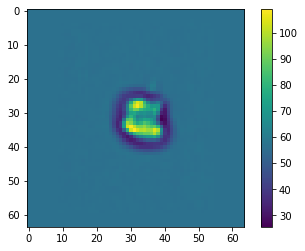

In [176]:
plt.imshow(next(iter(train_data1)))
plt.colorbar()

In [152]:
def Run_NN(train_data=train_data1,validation_data=validation_data1,model=resnet18(False,True),str_model='resnet18',batch_size=20,num_epochs = 25,lr=0.001):


    return diz_loss,str_model,ConvNet_simple,validation_loader,train_loader




In [153]:
def get_preds(NN,validation_loader):
    y_trues=[]
    y_preds=[]


    #validation_loader = DataLoader(validation_data, batch_size=int(len(validation_data)/10), shuffle=False)

    with torch.no_grad(): # No need to track the gradients

        for image_batch,labels_batch in validation_loader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)

            labels=labels_batch.to(device).detach().cpu().numpy()
            y_true=np.argmax(labels,axis=1)

            output=NN(image_batch).detach().cpu().numpy()
            y_pred=np.argmax(output,axis=1)

            y_trues.extend(list(y_true))
            y_preds.extend(list(y_pred))     



    conf=confusion_matrix(y_trues, y_preds,labels=cell_types)

    return y_trues,y_preds,conf



In [154]:
a=np.argsort(df['Cell_Type'].unique())
df['Cell_Type_str'].unique()[a]

array(['Other cell type', 'FITC (Smooth Muscle Actin)', 'APC (CD45)',
       'PE (Stromal cells)'], dtype=object)

In [155]:
np.unique(df['Cell_Type_str'].to_numpy())

array(['APC (CD45)', 'FITC (Smooth Muscle Actin)', 'Other cell type',
       'PE (Stromal cells)'], dtype=object)

In [156]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#from plotcm import plot_confusion_matrix
#plt.figure(figsize=(5,5),dpi=100)
##plot_confusion_matrix(conf, ["Singlet","Doublet","Debris"],normalize=True)


In [157]:
#Saving the model outputs

def save_output(diz_loss,str_model,y_trues,y_preds,conf):
    name=str_model
    mean_acc=round(np.mean(diz_loss['val_acc'][-5:]),2)
    new_dir=basepath+"\\Results\\"+name+'_'+str(mean_acc)

    dir=new_dir
    count=1
    while os.path.exists(dir):
        dir=new_dir+'('+str(count)+')'
        count+=1

    new_dir=dir
    os.mkdir(new_dir)

    destination1=new_dir+'\\Loss.csv'
    destination2=new_dir+'\\Predictions.csv'
    destination3=new_dir+'\\Confusion_mat.png'

    df1 = pd.DataFrame.from_dict(diz_loss)
    df1.to_csv (destination1, index = False, header=True)

    df1 = pd.DataFrame()
    df1['Cell_ID']  = validation_ID
    df1['Prediction']  = y_preds
    df1['Ground Truth']=y_trues
    df1.to_csv (destination2, index = False, header=True)

    fig=plt.figure(figsize=(5,5),dpi=150)
    a=np.argsort(df['Cell_Type'].unique())
    list_str=df['Cell_Type_str'].unique()[a]
    list_str=['Other','APC']
    plot_confusion_matrix(conf, list_str,normalize=True)
    fig.savefig(destination3,bbox_inches='tight', dpi=150)



 EPOCH 1  	 train loss 0.701472602193581  	 val loss 0.6782365185721069 	 train acc 55.375334357748564 	 val acc 61.56242511382698


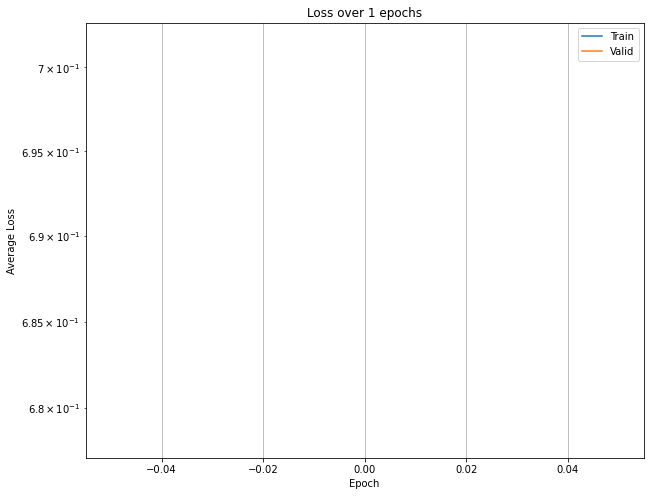

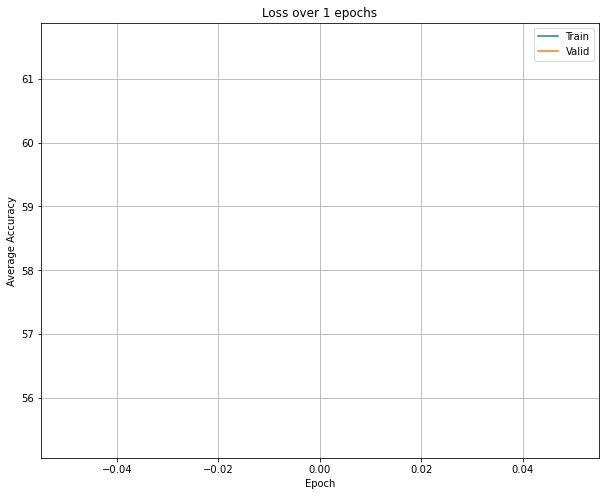

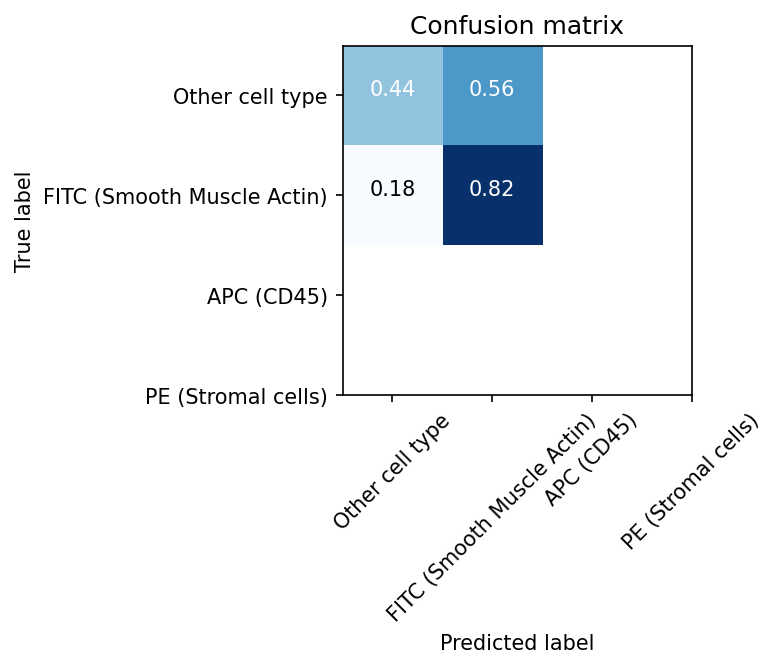

In [158]:
diz_loss,str_model,NN,validation_loader,train_loader=Run_NN(model=resnet18(),str_model='Resnet18',num_epochs=1,polar=False,batch_size=20)
y_trues,y_preds,conf=get_preds(NN,validation_loader)
save_output(diz_loss,str_model,y_trues,y_preds,conf)


In [159]:
y_trues,y_preds,conf=get_preds(NN,validation_loader)

In [160]:
y_trues,y_preds,conf=get_preds(NN,validation_loader)

In [161]:
cell_types=[0,1]

In [162]:
conf

array([[ 977, 1247],
       [ 357, 1592]], dtype=int64)

In [163]:
img=next(iter(train_loader))

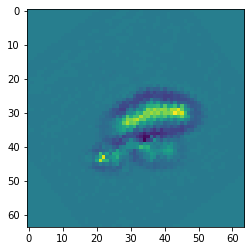

In [173]:
plt.imshow(img[0][5][0])

In [177]:
a=np.zeros((10,10))

In [178]:
df=pd.DataFrame(a)

In [180]:
df["Cell_OD"]=[1 for i in range(10)]

In [181]:
df

,0,1,2,3,4,5,6,7,8,9,Cell_OD
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
